In [1]:
!pip install pymorphy2
!pip install nltk
!pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.5/55.5 kB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 91.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13705 sha256=05ed46b850d3986c0e4d03b6ef2e24bbdad0dc9c0bfcfec04240a469ae61a358
  Stored in directory: /root/.cache/pip/wheels/fc/ab/d4/5da2067ac95b36618c629a5f93f809425700506f72c9732fac
Successfully built docopt
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 9.3 MB/s eta 0:00:00


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier

In [2]:
train = pd.read_csv('/content/train_data.csv')
test = pd.read_csv('/content/test_data.csv')

In [ ]:
train.shape, test.shape

((1669, 3), (10571, 4))

In [ ]:
train

,Unnamed: 0,sentence,label
0,0,Срыв сроков строительства зоопарка оценили в 1...,1
1,1,"По данным Генпрокуратуры РФ, в 2014-2018 годах...",1
2,2,"Обвиняли в этом столичный акимат, который сорв...",1
3,3,Запуск циклотронного центра ядерной медицины н...,1
4,4,Сроки сдачи объекта несколько раз переносились.,1
...,...,...,...
1664,1664,Подрядчик ООО «АльянсДорСтрой» должен сдать об...,0
1665,1665,"Он заявил, что запуск ракеты-носителя сверхтяж...",0
1666,1666,"Застройщик ЖК ""Медовая Долина"" планирует ввест...",0
1667,1667,"Официальные сроки, указанные в проектной декла...",0


In [ ]:
test

,Unnamed: 0,id,title,text
0,0.0,0,Графики обслуживания внутриквартирного и внутр...,В соответствии с п.42 Постановления Правительс...
1,1.0,1,На МЦД улучшили поезда,"В Москве, на Белорусско-Савеловском центрально..."
2,2.0,2,Катастрофа SSJ 100: вина за гибель 41 человека...,Завершено расследование дела о крушении самоле...
3,3.0,3,С Днем юриста!,От души поздравляем сотрудников и преподавател...
4,4.0,4,"Охота на ""черного"" лесоруба","В Костроме прошел межрегиональный форум, посвя..."
...,...,...,...,...
10566,10565.0,10565,Российские гандболистки разгромили ДР Конго на...,Сборная России по гандболу одержала третью поб...
10567,10566.0,10566,Опоздать на смерть,"Барышня, очаровательная, подходит ко мне после..."
10568,10567.0,10567,Футбольный клуб «Ростов» оскорбил спонсора,"История с многомиллионным займом, который «Гру..."
10569,10568.0,10568,О состоянии пострадавших в ДТП в Кызылординско...,НУР-СУЛТАН. КАЗИНФОРМ – Министр здравоохранени...


In [18]:
test.text[5]

'Вратарь «Ливерпуля» и сборной Бразилии Алисон Бекер высказался о победе нападающего «Барселоны» Лионеля Месси в борьбе за награду «Золотой мяч».«Сейчас Месси лучший не только потому, что он получил шесть «Золотых мячей». Это огромное достижение, но и потому, что он сделал для «Барселоны», — цитирует Алисона РИА «Новости».\nЦеремония вручения «Золотого мяча» прошла 2 декабря в Париже. «Газета.Ru» провела текстовую онлайн-трансляцию мероприятия.Ранее сообщалось, что Алисон получил премию Льва Яшина.'

In [3]:
test['concat_text'] = test['title'] + ' ' + test['text']
test['concat_text'] = test['concat_text'].astype(str)

<Axes: >

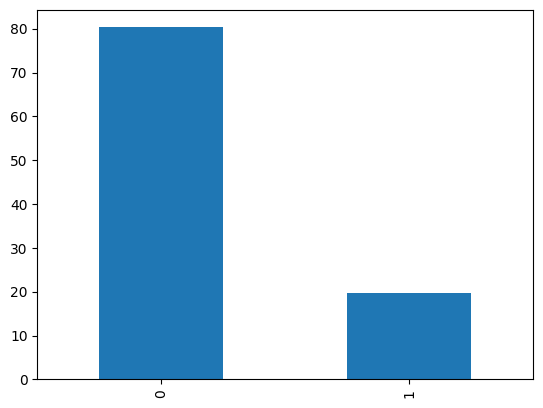

In [4]:
round(train.label.value_counts() / len(train) * 100, 2).plot.bar()

In [5]:
train.sentence.values[-5:]

array(['Подрядчик ООО «АльянсДорСтрой» должен сдать объект в первом квартале 2020 года, но строители взяли на себя обязательство сдать объект досрочно в декабре нынешнего года.',
       'Он заявил, что запуск ракеты-носителя сверхтяжелого класса с космодрома должен состояться в 2028 году.',
       'Застройщик ЖК "Медовая Долина" планирует ввести объект в срок',
       'Официальные сроки, указанные в проектной декларации столичного ЖК "Медовая долина", подразумевают ввод в эксплуатацию второй и третьей очередей (корпуса №4-9) во втором квартале 2020 года',
       'Он потребовал «выдержать намеченные сроки» строительства космодрома Восточный и запуска с него ракет-носителей.'],
      dtype=object)

In [6]:
train.sentence.values[:5]

array(['Срыв сроков строительства зоопарка оценили в 1 млрд рублей Управление капстроительства намерено взыскать в арбитраже 1 млрд руб. с АО "РЖДстрой" в качестве неустойки за срыв срока сдачи первой очереди зоопарка.',
       'По данным Генпрокуратуры РФ, в 2014-2018 годах выявили 17 тысяч различных нарушений - хищение бюджетных средств, затягивание сроков строительства, невыплата зарплат и другие факты, происходившие при возведении космодрома.',
       'Обвиняли в этом столичный акимат, который сорвал сроки строительства первого и второго пусковых комплексов первой очереди газораспределительных сетей.',
       'Запуск циклотронного центра ядерной медицины на базе УрФУ откладывается из-за неоконченных пуско-наладочных работ канадского циклотрона TR-24.',
       'Сроки сдачи объекта несколько раз переносились.'], dtype=object)

In [10]:
test.concat_text.values[:5]

array(['Графики обслуживания внутриквартирного и внутридомового газового оборудования В соответствии с п.42 Постановления Правительства РФ от 14.05.2013г. №410, собственники жилых помещений в многоквартирном доме и частных домовладений обязаны обеспечивать доступ представителей специализированной организации к внутридомовому и (или) внутриквартирному газовому оборудованию для проведения работ (оказания услуг) по техническому обслуживанию и ремонту указанного оборудования (ТО ВДГО). В целях обеспечения безопасности жизни и здоровья граждан, предотвращения возможных аварийных ситуаций при эксплуатации внутриквартирного и внутридомового газового оборудования собственникам квартир и домовладений необходимо обеспечить доступ для планового проведения ТО ВДГО специалистами АО «Шадринскмежрайгаз». О дате проведения работ по ТО ВДГО можно узнать в газете «Ваша выгода» № 98 от 11.12.2018 г, на сайте АО «Шадринскмежрайгаз» www.kurgangazcom.ru в разделе «Графики обслуживания ВДГО», по телефону 04 

# Preprocessing

In [4]:
import nltk
import pymorphy2
from nltk.corpus import stopwords
import string
import re
nltk.download('stopwords')
stopwords = stopwords.words("russian")
morph_analyzer = pymorphy2.MorphAnalyzer()
grams_exclusion = ['NUMB', 'Geox', 'Orgn', 'Name', 'Surn']

def norm_text(txt, stopwords, morph):
    ans = []
    txt = txt.lower()
    txt = txt.strip()
    txt = re.sub('https?://\S+|www\.\S+', '', txt)
    txt = " ".join(re.findall(r'[\w\d]+', txt))
    txt = txt.replace("  ", " ")
    txt = " ".join([word for word in str(txt).split() if word not in stopwords])
    for word in txt.split():
      parsed = morph.parse(word)[0]
      ans.append(parsed.normal_form)
      for gram in grams_exclusion:
        if gram in parsed.tag:
          ans[-1] = f'[{gram.upper()}]'
          break
    return " ".join(ans)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
example = train.sentence.values[1]

In [5]:
example

'По данным Генпрокуратуры РФ, в 2014-2018 годах выявили 17 тысяч различных нарушений - хищение бюджетных средств, затягивание сроков строительства, невыплата зарплат и другие факты, происходившие при возведении космодрома.'

In [6]:
norm_text(example, stopwords, morph_analyzer)

'данные [ORGN] [GEOX] [NUMB] [NUMB] год выявить [NUMB] тысяча различный нарушение хищение бюджетный средство затягивание срок строительство невыплата зарплата другой факт происходить возведение космодром'

In [5]:
from tqdm.notebook import tqdm
tqdm.pandas()
train['norm_sent'] = train['sentence'].progress_apply(lambda x: norm_text(x, stopwords, morph_analyzer))
test['concat_text'] = test['concat_text'].progress_apply(lambda x: norm_text(x, stopwords, morph_analyzer))

  0%|          | 0/1669 [00:00<?, ?it/s]

  0%|          | 0/10571 [00:00<?, ?it/s]

In [6]:
train.norm_sent.values[:10]

array(['срыв срок строительство зоопарк оценить [NUMB] млрд рубль управление капстроительство намерить взыскать арбитраж [NUMB] млрд руб [ORGN] рждстроить качество неустойка срыв срок сдача первый очередь зоопарк',
       'данные [ORGN] [GEOX] [NUMB] [NUMB] год выявить [NUMB] тысяча различный нарушение хищение бюджетный средство затягивание срок строительство невыплата зарплата другой факт происходить возведение космодром',
       'обвинять столичный акимат который сорвать срок строительство первый второй пусковой комплекс первый очередь газораспределительный сеть',
       'запуск циклотронный центр ядерный медицина база [GEOX] откладываться неоконченный [GEOX] наладочный работа канадский циклотрон tr [NUMB]',
       'срок сдача объект несколько переноситься',
       'построить последний участок северный обход [GEOX] планироваться ранее [NUMB] г завершить работа строительство трасса первоначально планироваться начало чемпионат мир футбол [NUMB] г срок неоднократно переноситься',
      

898 13


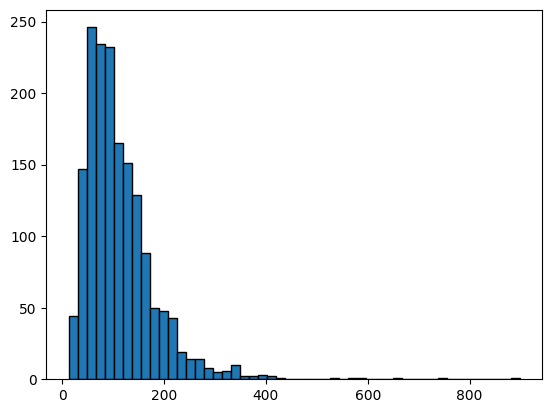

In [9]:
len_seq = []
for seq in train.norm_sent:
  len_seq.append(len(seq))

print(max(len_seq), min(len_seq))
plt.hist(len_seq, bins=50, ec='black')
plt.show()

In [10]:
def top_n_freq_words(df, n):
  d = {}
  for sent in df.norm_sent:
    for w in sent.split():
      if w not in ['[NUMB]', '[GEOX]', '[ORGN]', '[NAME]', '[SURN]']:
        d[w] = 1 + d.get(w, 0)
  d = {k: v for k, v in sorted(d.items(), key=lambda x: x[1], reverse=True)}
  return list(d.items())[:n]

In [11]:
top_n_freq_words(train[train.label == 1], 10)

[('срок', 189),
 ('год', 139),
 ('эксплуатация', 118),
 ('строительство', 105),
 ('дом', 102),
 ('ввод', 99),
 ('задержка', 76),
 ('сдача', 71),
 ('объект', 61),
 ('компания', 56)]

In [12]:
top_n_freq_words(train[train.label == 0], 10)

[('год', 293),
 ('дом', 257),
 ('строительство', 250),
 ('застройщик', 176),
 ('срок', 154),
 ('объект', 153),
 ('который', 145),
 ('дольщик', 138),
 ('компания', 123),
 ('работа', 120)]

# Baseline (BoW & Log-reg)

In [13]:
X_train, X_test, y_train, y_test = train_test_split(train.norm_sent, train.label, test_size=0.2, stratify=train.label, random_state=123, shuffle=True)

In [14]:
round(y_train.value_counts() / len(y_train) * 100, 2)

0    80.3
1    19.7
Name: label, dtype: float64

In [15]:
round(y_test.value_counts() / len(y_test) * 100, 2)

0    80.24
1    19.76
Name: label, dtype: float64

In [16]:
X_train.shape, X_test.shape

((1335,), (334,))

In [17]:
vectorizer = CountVectorizer(ngram_range=(1, 1))
X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)

In [18]:
log_reg = LogisticRegression(random_state=123)
log_reg.fit(X_train, y_train)

LogisticRegression(random_state=123)

In [19]:
y_pred_log = log_reg.predict_proba(X_test)[:, 1]
y_pred_target = log_reg.predict(X_test)

In [20]:
print(classification_report(y_test, y_pred_target))

              precision    recall  f1-score   support

           0       0.90      0.96      0.93       268
           1       0.76      0.59      0.67        66

    accuracy                           0.88       334
   macro avg       0.83      0.77      0.80       334
weighted avg       0.88      0.88      0.88       334



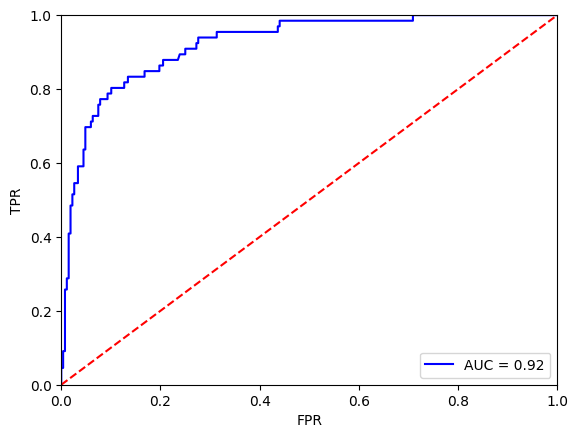

In [21]:
fpr, tpr, threshold = roc_curve(y_test, y_pred_log)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('TPR')
plt.xlabel('FPR')
plt.show()

# CatBoost & LGBM

In [22]:
X_train, X_test, y_train, y_test = train_test_split(train.norm_sent, train.label, test_size=0.2, random_state=123, shuffle=True)

vectorizer = CountVectorizer(ngram_range=(1, 1))
X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)

In [23]:
catb_class = CatBoostClassifier(random_state=123)
catb_class.fit(X_train, y_train)

Learning rate set to 0.011655
0:	learn: 0.6859894	total: 81.2ms	remaining: 1m 21s
1:	learn: 0.6747831	total: 99.8ms	remaining: 49.8s
2:	learn: 0.6654408	total: 120ms	remaining: 39.9s
3:	learn: 0.6567731	total: 139ms	remaining: 34.5s
4:	learn: 0.6485059	total: 169ms	remaining: 33.7s
5:	learn: 0.6422776	total: 183ms	remaining: 30.3s
6:	learn: 0.6334263	total: 194ms	remaining: 27.6s
7:	learn: 0.6258252	total: 203ms	remaining: 25.2s
8:	learn: 0.6183186	total: 222ms	remaining: 24.4s
9:	learn: 0.6106131	total: 241ms	remaining: 23.8s
10:	learn: 0.6043729	total: 255ms	remaining: 22.9s
11:	learn: 0.5971679	total: 273ms	remaining: 22.5s
12:	learn: 0.5920514	total: 291ms	remaining: 22.1s
13:	learn: 0.5837473	total: 311ms	remaining: 21.9s
14:	learn: 0.5775161	total: 341ms	remaining: 22.4s
15:	learn: 0.5730804	total: 359ms	remaining: 22.1s
16:	learn: 0.5653800	total: 375ms	remaining: 21.7s
17:	learn: 0.5591914	total: 397ms	remaining: 21.6s
18:	learn: 0.5534517	total: 416ms	remaining: 21.5s
19:	lear

In [24]:
y_pred_log = catb_class.predict_proba(X_test)[:, 1]
y_pred_target = catb_class.predict(X_test)

In [25]:
print(classification_report(y_test, y_pred_target))

              precision    recall  f1-score   support

           0       0.90      0.98      0.94       262
           1       0.91      0.58      0.71        72

    accuracy                           0.90       334
   macro avg       0.90      0.78      0.83       334
weighted avg       0.90      0.90      0.89       334



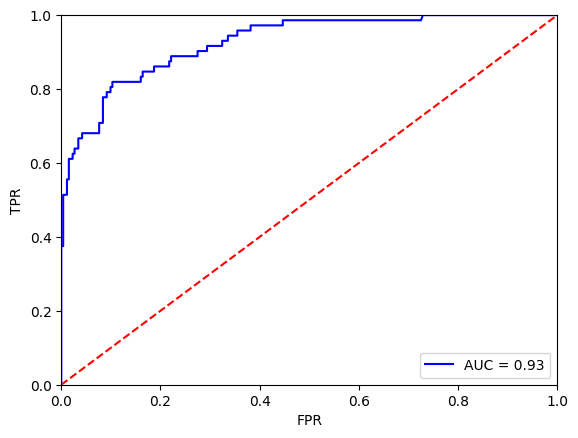

In [26]:
fpr, tpr, threshold = roc_curve(y_test, y_pred_log)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('TPR')
plt.xlabel('FPR')
plt.show()

In [27]:
lgb_class = LGBMClassifier(random_state=123)
lgb_class.fit(X_train.astype(np.float32), y_train)

[LightGBM] [Info] Number of positive: 257, number of negative: 1078
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001280 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 387
[LightGBM] [Info] Number of data points in the train set: 1335, number of used features: 134
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.192509 -> initscore=-1.433787
[LightGBM] [Info] Start training from score -1.433787


LGBMClassifier(random_state=123)

In [28]:
y_pred_log = lgb_class.predict_proba(X_test.astype(np.float32))[:, 1]
y_pred_target = lgb_class.predict(X_test.astype(np.float32))

In [29]:
print(classification_report(y_test, y_pred_target))

              precision    recall  f1-score   support

           0       0.90      0.97      0.93       262
           1       0.85      0.61      0.71        72

    accuracy                           0.89       334
   macro avg       0.87      0.79      0.82       334
weighted avg       0.89      0.89      0.89       334



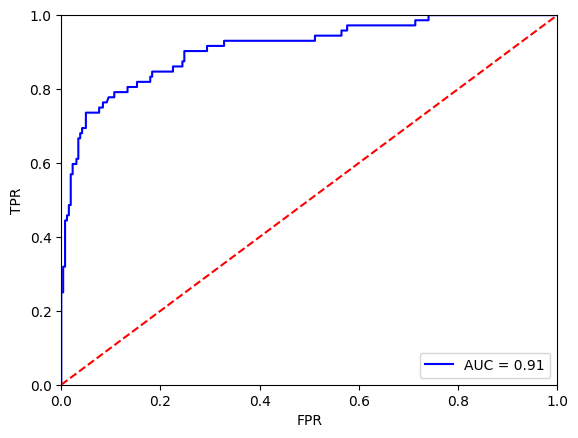

In [30]:
fpr, tpr, threshold = roc_curve(y_test, y_pred_log)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('TPR')
plt.xlabel('FPR')
plt.show()

# NN approach (rubert-tiny2)

In [6]:
!pip install -q transformers
!pip install transformers[torch]
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 28.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 21.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 50.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 50.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 251.2/251.2 kB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.3/519.3 kB 11.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 16.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 25.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 19.6 MB/s eta 0:00:00


## Create dataset

In [7]:
from datasets import Dataset
dataset = Dataset.from_pandas(train)
dataset = dataset.remove_columns(['Unnamed: 0', 'sentence'])
dataset = dataset.rename_column('norm_sent', 'text')
dataset = dataset.train_test_split(test_size=0.2, shuffle=True, seed=123)

In [8]:
dataset

DatasetDict({
    train: Dataset({
        features: ['label', 'text'],
        num_rows: 1335
    })
    test: Dataset({
        features: ['label', 'text'],
        num_rows: 334
    })
})

## Train

In [7]:
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AutoConfig
tokenizer = AutoTokenizer.from_pretrained("cointegrated/rubert-tiny2")
model = AutoModelForSequenceClassification.from_pretrained("cointegrated/rubert-tiny2")

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at cointegrated/rubert-tiny2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [9]:
model.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(83828, 312, padding_idx=0)
      (position_embeddings): Embedding(2048, 312)
      (token_type_embeddings): Embedding(2, 312)
      (LayerNorm): LayerNorm((312,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-2): 3 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=312, out_features=312, bias=True)
              (key): Linear(in_features=312, out_features=312, bias=True)
              (value): Linear(in_features=312, out_features=312, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=312, out_features=312, bias=True)
              (LayerNorm): LayerNorm((312,), eps=1e-12, 

In [10]:
config = AutoConfig.from_pretrained("cointegrated/rubert-tiny2")
config

BertConfig {
  "_name_or_path": "cointegrated/rubert-tiny2",
  "architectures": [
    "BertForPreTraining"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "emb_size": 312,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 312,
  "initializer_range": 0.02,
  "intermediate_size": 600,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 2048,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 3,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "torch_dtype": "float32",
  "transformers_version": "4.32.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 83828
}

In [11]:
def tokenize_function(txt):
    return tokenizer(txt["text"], truncation=True)

In [12]:
tokenized_dataset = dataset.map(tokenize_function, batched=True)

Map:   0%|          | 0/1335 [00:00<?, ? examples/s]

Map:   0%|          | 0/334 [00:00<?, ? examples/s]

In [13]:
from transformers import DataCollatorWithPadding

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [14]:
from transformers import TrainingArguments, Trainer

In [15]:
training_args = TrainingArguments(
    output_dir="rubert_tiny2",
    learning_rate=1e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=12,
    weight_decay=0.01,
    logging_strategy = "steps",
    evaluation_strategy="steps",
    save_strategy="steps",
    logging_steps=84,
    save_steps=84,
    seed=123,
    fp16=True,
    load_best_model_at_end=True,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["test"],
    tokenizer=tokenizer,
    data_collator=data_collator,
)

In [16]:
trainer.train()

You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Step,Training Loss,Validation Loss
84,0.567700,0.494782
168,0.483400,0.452735
252,0.432800,0.389917
336,0.371700,0.343476
420,0.326200,0.324045
504,0.294600,0.318864
588,0.279500,0.312191
672,0.269500,0.308082
756,0.256900,0.311690
840,0.243900,0.310352


TrainOutput(global_step=1008, training_loss=0.33495030138227677, metrics={'train_runtime': 54.1737, 'train_samples_per_second': 295.715, 'train_steps_per_second': 18.607, 'total_flos': 12967010065620.0, 'train_loss': 0.33495030138227677, 'epoch': 12.0})

## Eval

In [5]:
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AutoConfig
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

tokenizer = AutoTokenizer.from_pretrained("/content/rubert_tiny2/checkpoint-672")
model = AutoModelForSequenceClassification.from_pretrained("/content/rubert_tiny2/checkpoint-672")
model.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(83828, 312, padding_idx=0)
      (position_embeddings): Embedding(2048, 312)
      (token_type_embeddings): Embedding(2, 312)
      (LayerNorm): LayerNorm((312,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-2): 3 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=312, out_features=312, bias=True)
              (key): Linear(in_features=312, out_features=312, bias=True)
              (value): Linear(in_features=312, out_features=312, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=312, out_features=312, bias=True)
              (LayerNorm): LayerNorm((312,), eps=1e-12, 

In [9]:
tokenized_eval = tokenizer(dataset['test']["text"], truncation=True, return_tensors='pt', padding=True)

In [10]:
with torch.no_grad():
  preds = model(**tokenized_eval.to(device)).logits
  labels = np.array(dataset['test']['label'])

In [11]:
# torch.cuda.empty_cache()

In [12]:
prob = torch.nn.functional.softmax(preds, dim=1)[:, 1].cpu().detach().numpy()
pred_target = preds.argmax(axis=1).cpu().detach().numpy()

In [15]:
print(classification_report(labels, pred_target))

              precision    recall  f1-score   support

           0       0.94      0.90      0.92       271
           1       0.63      0.75      0.68        63

    accuracy                           0.87       334
   macro avg       0.78      0.82      0.80       334
weighted avg       0.88      0.87      0.87       334



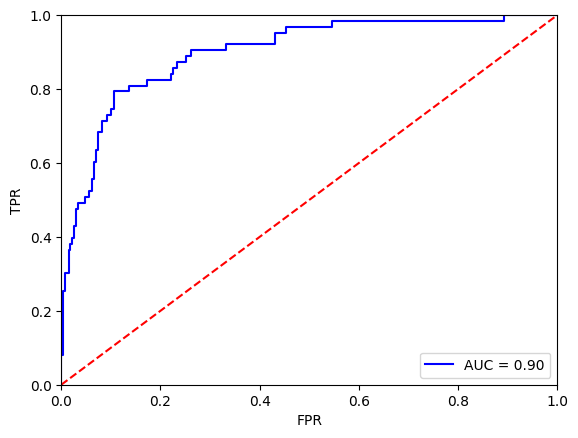

In [16]:
fpr, tpr, threshold = roc_curve(labels, prob)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('TPR')
plt.xlabel('FPR')
plt.show()

In [17]:
!zip -r tiny2_checkpoint.zip /content/rubert_tiny2/checkpoint-672

  adding: content/rubert_tiny2/checkpoint-672/ (stored 0%)
  adding: content/rubert_tiny2/checkpoint-672/optimizer.pt (deflated 88%)
  adding: content/rubert_tiny2/checkpoint-672/config.json (deflated 49%)
  adding: content/rubert_tiny2/checkpoint-672/pytorch_model.bin (deflated 8%)
  adding: content/rubert_tiny2/checkpoint-672/tokenizer.json (deflated 73%)
  adding: content/rubert_tiny2/checkpoint-672/scheduler.pt (deflated 49%)
  adding: content/rubert_tiny2/checkpoint-672/trainer_state.json (deflated 76%)
  adding: content/rubert_tiny2/checkpoint-672/vocab.txt (deflated 64%)
  adding: content/rubert_tiny2/checkpoint-672/tokenizer_config.json (deflated 50%)
  adding: content/rubert_tiny2/checkpoint-672/rng_state.pth (deflated 28%)
  adding: content/rubert_tiny2/checkpoint-672/special_tokens_map.json (deflated 42%)
  adding: content/rubert_tiny2/checkpoint-672/training_args.bin (deflated 49%)


# Create result prediction

In [7]:
from datasets import Dataset
test_dataset = Dataset.from_pandas(test)
test_dataset = test_dataset.remove_columns(['Unnamed: 0', 'id', 'title', 'text'])
test_dataset = test_dataset.rename_column('concat_text', 'text')

In [8]:
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AutoConfig
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

tokenizer = AutoTokenizer.from_pretrained("/content/rubert_tiny2/checkpoint-672")
model = AutoModelForSequenceClassification.from_pretrained("/content/rubert_tiny2/checkpoint-672")
model.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(83828, 312, padding_idx=0)
      (position_embeddings): Embedding(2048, 312)
      (token_type_embeddings): Embedding(2, 312)
      (LayerNorm): LayerNorm((312,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-2): 3 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=312, out_features=312, bias=True)
              (key): Linear(in_features=312, out_features=312, bias=True)
              (value): Linear(in_features=312, out_features=312, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=312, out_features=312, bias=True)
              (LayerNorm): LayerNorm((312,), eps=1e-12, 

In [9]:
tokenized_test = tokenizer(test_dataset["text"], truncation=True, padding=True)

In [10]:
tokenized_test_dataset = Dataset.from_dict(tokenized_test)
tokenized_test_dataset.set_format(type="torch", columns=["input_ids", "token_type_ids", "attention_mask"])

In [11]:
from torch.utils.data import DataLoader
dataloader = DataLoader(tokenized_test_dataset, batch_size=16)

In [12]:
from tqdm.notebook import tqdm
answ = []
with torch.no_grad():
  for batch in tqdm(dataloader):
    input_ids, attention_mask, token_type_ids = batch['input_ids'].to(device), batch['attention_mask'].to(device), batch['token_type_ids'].to(device)
    preds = model(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids).logits
    prob = torch.nn.functional.softmax(preds, dim=1)[:, 1].cpu().detach().numpy()
    answ.append(prob)

  0%|          | 0/661 [00:00<?, ?it/s]

In [13]:
final_answ = np.hstack(answ)

In [14]:
len(final_answ)

10571

In [15]:
max(final_answ), min(final_answ)

(0.7743889, 0.030078406)

In [16]:
test['pred_prob'] = final_answ
test = test.drop(columns=['concat_text'])
test

,Unnamed: 0,id,title,text,pred_prob
0,0.0,0,Графики обслуживания внутриквартирного и внутр...,В соответствии с п.42 Постановления Правительс...,0.067713
1,1.0,1,На МЦД улучшили поезда,"В Москве, на Белорусско-Савеловском центрально...",0.187879
2,2.0,2,Катастрофа SSJ 100: вина за гибель 41 человека...,Завершено расследование дела о крушении самоле...,0.245508
3,3.0,3,С Днем юриста!,От души поздравляем сотрудников и преподавател...,0.048111
4,4.0,4,"Охота на ""черного"" лесоруба","В Костроме прошел межрегиональный форум, посвя...",0.208443
...,...,...,...,...,...
10566,10565.0,10565,Российские гандболистки разгромили ДР Конго на...,Сборная России по гандболу одержала третью поб...,0.051821
10567,10566.0,10566,Опоздать на смерть,"Барышня, очаровательная, подходит ко мне после...",0.415626
10568,10567.0,10567,Футбольный клуб «Ростов» оскорбил спонсора,"История с многомиллионным займом, который «Гру...",0.087526
10569,10568.0,10568,О состоянии пострадавших в ДТП в Кызылординско...,НУР-СУЛТАН. КАЗИНФОРМ – Министр здравоохранени...,0.050970


In [17]:
test.to_csv('result_test_task.csv')